In [1]:
import os 
from pathlib import Path

In [5]:
import pandas as pd
df = pd.read_csv("results__segm_elythra.csv")

In [8]:
df = df[df['group_image'].str.endswith(('1831', '41414', '34542', '33672', '33571'))]

In [22]:
good_examples = ['251', '592', '958', '959', '186', '401', '515', '190', '363', '501', '314', '315', '5950'] 
df = df[df['individual_image'].str.split('.').str[0].str.endswith(tuple(good_examples))]
df = df.reset_index(drop=True)

In [23]:
df

,group_image,individual_image,px_to_cm
0,A00000033672,beetle_314.png,418
1,A00000033672,beetle_315.png,418
2,A00000034542,beetle_501.png,233
3,A00000034542,beetle_190.png,233
4,A00000034542,beetle_363.png,233
5,A00000041414,beetle_401.png,223
6,A00000041414,beetle_186.png,223
7,A00000041414,beetle_515.png,223
8,A00000001831,beetle_251.png,300
9,A00000001831,beetle_958.png,300


In [15]:
seg_dir = Path("data/elythra_segmented/")

In [33]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

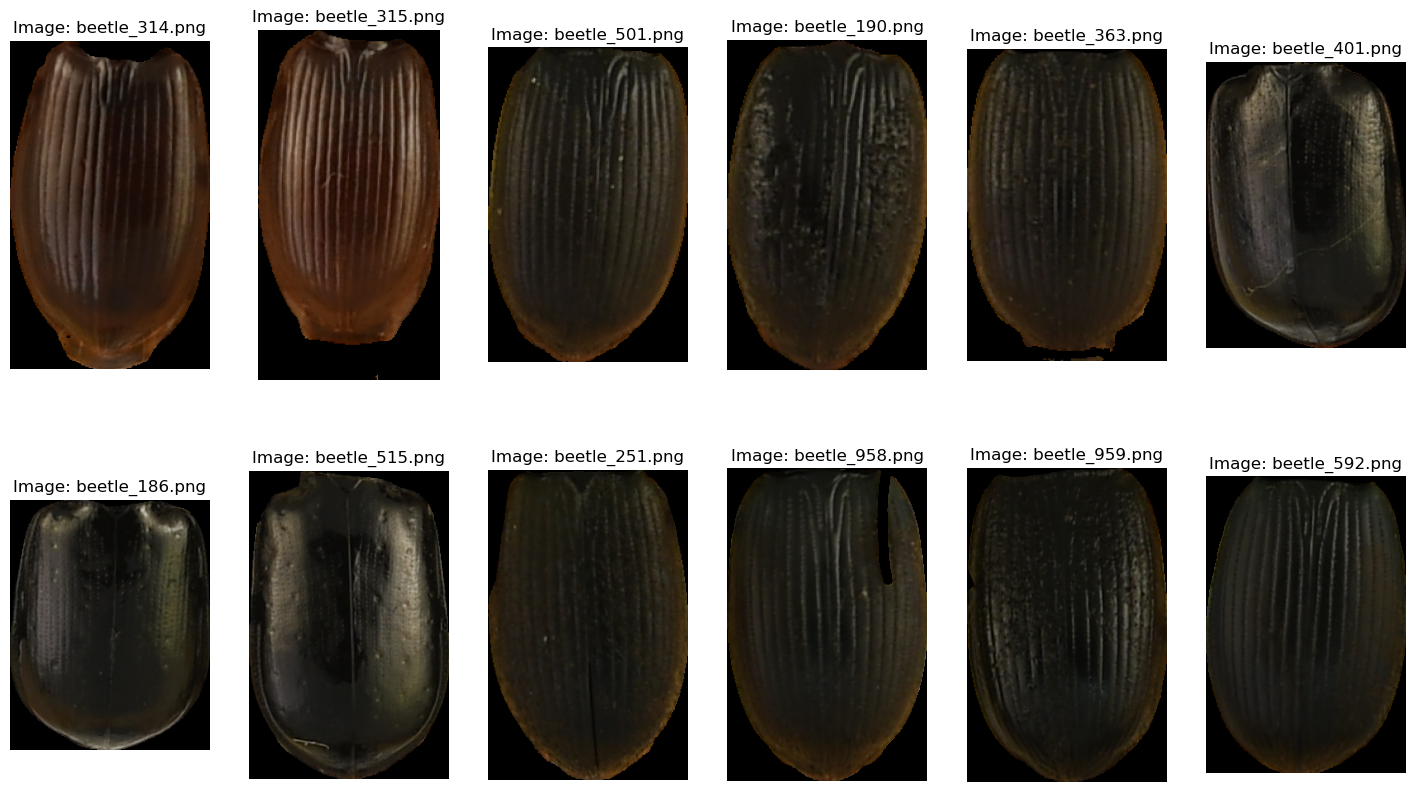

In [26]:
plt.figure(figsize=(18,10))

for index, row in df.iterrows():
    
    image_filename = row['individual_image']
    image_filepath = seg_dir/row['group_image']/image_filename
    
    img = cv2.imread(image_filepath)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 6, index + 1)
    plt.imshow(img_rgb)
    plt.title(f"Image: {image_filename}")
    plt.axis('off')

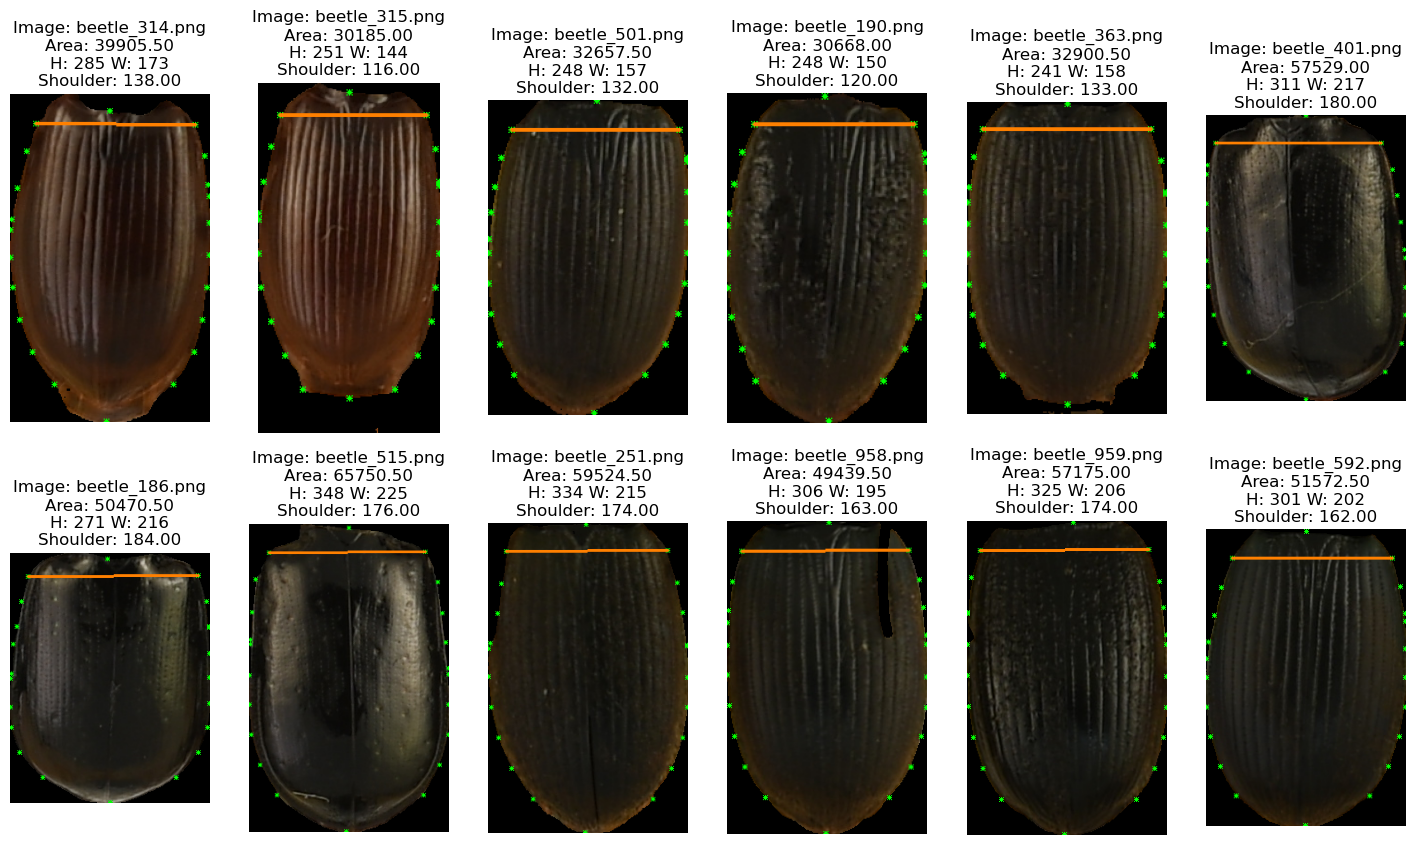

In [89]:
plt.figure(figsize=(18,10))

for index, row in df.iterrows():
    
    image_filename = row['individual_image']
    image_filepath = seg_dir/row['group_image']/image_filename
    px_cm = int(row["px_to_cm"])
    
    img = cv2.imread(image_filepath)
    w, h, _ = img.shape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    img_gray = clahe.apply(img_gray)

    # Canny
    # edges = cv2.Canny(img_gray, 50, 150, 3)

    # Sobel 
    # sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    # sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    # edges = cv2.magnitude(sobelx, sobely) 

    # Prewitt
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    prewittx = cv2.filter2D(img_gray, cv2.CV_32F, kernelx)
    prewitty = cv2.filter2D(img_gray, cv2.CV_32F, kernely)
    edges = cv2.magnitude(prewittx, prewitty)
    edges_uint8 = cv2.convertScaleAbs(edges)
    
    _, binary = cv2.threshold(edges_uint8, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boundary_edges = np.zeros_like(edges_uint8)

    min_contour_area = 500
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    
    cv2.drawContours(boundary_edges, large_contours, -1, (255), 1)
    largest_contour = max(large_contours, key=cv2.contourArea)
    
    cv2.drawContours(boundary_edges, [largest_contour], -1, (255), 1)
    
    area = cv2.contourArea(largest_contour)
    x, y, w, h = cv2.boundingRect(largest_contour)
    max_vertical_distance = h
    max_horizontal_distance = w

    # Add custom landmarks
    height, width = img_gray.shape
    partitions = 10
    step = height // partitions

    landmarks = []
    label = 1

    for i in range(partitions):
        y_start = i * step
        y_end = (i + 1) * step if i != partitions-1 else height
        vertical_slice = boundary_edges[y_start:y_end, :]

        edge_points = np.column_stack(np.where(vertical_slice > 0))
        
        if len(edge_points) > 0:
            edge_points[:, 0] += y_start
            leftmost = edge_points[np.argmin(edge_points[:, 1])]
            rightmost = edge_points[np.argmax(edge_points[:, 1])]

            if i == 0 or i == partitions-1:
                middle_x = width // 2
                middle_points = edge_points[(edge_points[:, 1] > middle_x - partitions) & (edge_points[:, 1] < middle_x + partitions)]
                if len(middle_points) > 0:
                    middle = middle_points[len(middle_points) // 2]
                    landmarks.append((middle, label))
                    label += 1

            landmarks.append((leftmost, label))
            label += 1
            landmarks.append((rightmost, label))
            label += 1

    landmarks.sort(key=lambda x: (x[0][0], x[0][1]))
    output_image = img_rgb.copy()
    for point, lbl in landmarks:
        cv2.drawMarker(output_image, (point[1], point[0]), (0, 255, 0), markerType=cv2.MARKER_STAR, markerSize= 4, thickness=1)

    point1 = landmarks[1][0]  # Landmark label 2
    point2 = landmarks[2][0]  # Landmark label 3
    shoulder_distance = np.linalg.norm(np.array(point2) - np.array(point1))
    cv2.line(output_image, (point1[1], point1[0]), (point2[1], point2[0]), (255, 128, 0), 2)

    plt.subplot(2, 6, index + 1)
    plt.imshow(output_image)
    plt.title(f"Image: {image_filename}\nArea: {area:.2f}\nH: {max_vertical_distance} W: {max_horizontal_distance}\nShoulder: {shoulder_distance:.2f}")
    plt.axis('off')
    
plt.show()